In [1]:
import warnings
warnings.filterwarnings('ignore')

Load the dataset

In [2]:
import pandas as pd

In [3]:
# Read the CSV file
rating = pd.read_csv(
    '/kaggle/input/amazon-cell-phones-and-accessories-reviews/'
    'Cell_Phones_and_Accessories.csv/Cell_Phones_and_Accessories.csv'
)
print('Data loaded.')

Data loaded.


In [4]:
rating.head()

,user_id,parent_asin,rating,timestamp
0,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,B079BPGF6C,5.0,1534443517349
1,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,B08L6L3X1S,4.0,1612044451196
2,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,B00A8ZDL9Y,5.0,1408994588000
3,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,B07XRDHDNQ,4.0,1590470082910
4,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,B0BBGGC8F2,5.0,1629235304798


In [5]:
# show timestamps as date and time format
rating['date_time'] = pd.to_datetime(rating['timestamp'], unit='ms')

In [6]:
rating.head()

,user_id,parent_asin,rating,timestamp,date_time
0,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,B079BPGF6C,5.0,1534443517349,2018-08-16 18:18:37.349
1,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,B08L6L3X1S,4.0,1612044451196,2021-01-30 22:07:31.196
2,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,B00A8ZDL9Y,5.0,1408994588000,2014-08-25 19:23:08.000
3,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,B07XRDHDNQ,4.0,1590470082910,2020-05-26 05:14:42.910
4,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,B0BBGGC8F2,5.0,1629235304798,2021-08-17 21:21:44.798


In [7]:
print(f'Number of records: {len(rating):,}')

Number of records: 20,560,480


Filter the data to include only ratings of 3 or higher

In [8]:
rating = rating[rating['rating'] >= 3]
print(f'Filtered data to include ratings of 3 or higher. Remaining records: {len(rating):,}')

Filtered data to include ratings of 3 or higher. Remaining records: 16,559,009


Select a subset for analysis

In [9]:
rating_subset = rating.iloc[:50000]  # Adjust based on data size and needs

Prepare the user-item matrix using the correct column name

In [10]:
user_item_matrix = rating_subset.pivot(index='user_id', columns='parent_asin', values='rating').fillna(0)

Standardize the data for clustering

In [11]:
from sklearn.preprocessing import StandardScaler

In [12]:
scaler = StandardScaler()
data_reduced = scaler.fit_transform(user_item_matrix)
print('Data preprocessed.')

Data preprocessed.


Perform clustering with CS-Kmeans

In [13]:
import numpy as np
from scipy.special import gamma
from sklearn.metrics.pairwise import euclidean_distances

In [14]:
# Lévy flight function for the Cuckoo Search optimization
def levy_flight(lambda_=1.5, dimensions=1):
    sigma = (gamma(1 + lambda_) * np.sin(np.pi * lambda_ / 2) /
             (gamma((1 + lambda_) / 2) * lambda_ * 2 ** ((lambda_ - 1) / 2))) ** (1 / lambda_)
    u = np.random.normal(0, sigma, size=dimensions)
    v = np.random.normal(0, 1, size=dimensions)
    step = u / (np.abs(v) ** (1 / lambda_))
    return step

In [15]:
# Functions to initialize cuckoos, update their positions, and evaluate their fitness in CS-Kmeans
def initialize_cuckoos(n, data):
    cuckoos = np.random.rand(n, data.shape[1])
    return cuckoos


def update_cuckoos(cuckoos, data, pa=0.25):
    for i in range(len(cuckoos)):
        step = levy_flight(lambda_=1.5, dimensions=data.shape[1])
        cuckoos[i] += step * (np.random.rand() < pa)
        cuckoos[i] = np.clip(cuckoos[i], a_min=0, a_max=1)
    return cuckoos


def evaluate_fitness(cuckoo, data):
    distances = euclidean_distances(data, cuckoo.reshape(1, -1))
    return -np.sum(np.min(distances, axis=1))

In [16]:
from tqdm import tqdm

In [17]:
# CS-Kmeans Clustering
def cs_kmeans(data, n=10, max_iterations=100):
    cuckoos = initialize_cuckoos(n, data)
    best_fitness = float('-inf')
    best_cuckoo_ = None
    user_clusters_ = np.zeros(data.shape[0], dtype=int)

    for iteration in tqdm(range(max_iterations)):
        cuckoos = update_cuckoos(cuckoos, data)
        for i, cuckoo in enumerate(cuckoos):
            fitness = evaluate_fitness(cuckoo, data)
            if fitness > best_fitness:
                best_fitness = fitness
                best_cuckoo_ = cuckoo

        if iteration == max_iterations - 1:
            for i, user_data in enumerate(data):
                distances = euclidean_distances(user_data.reshape(1, -1), cuckoos)
                user_clusters_[i] = np.argmin(distances)

    return best_cuckoo_, user_clusters_

In [18]:
best_cuckoo, user_clusters = cs_kmeans(data_reduced, n=5, max_iterations=50)
print('Clustering completed.')

100%|██████████| 50/50 [04:42<00:00,  5.65s/it]

Clustering completed.


Choose a random target user and identify their cluster

In [19]:
import random

In [20]:
target_user_id = random.choice(user_item_matrix.index.tolist())
target_cluster = user_clusters[user_item_matrix.index.get_loc(target_user_id)]
print(f'Target User: {target_user_id}, Cluster: {target_cluster + 1}')

Target User: AHK5WGRRDPYA6IT5NKH7ZLKH4ECQ, Cluster: 5


Retrieve and print a part of user IDs in the same cluster

In [21]:
cluster_user_indices = [i for i, cluster in enumerate(user_clusters) if cluster == target_cluster]
cluster_user_ids = user_item_matrix.index[cluster_user_indices].tolist()
sample_size = 10  # Change this number to adjust the number of users to display
print(
    f'A sample of users in the same cluster as Target User {target_user_id}: '
    f'{random.sample(cluster_user_ids, min(sample_size, len(cluster_user_ids)))}'
)

A sample of users in the same cluster as Target User AHK5WGRRDPYA6IT5NKH7ZLKH4ECQ: ['AGZGA2B5XSMI45L7T3TJM6SZZ4LQ', 'AF62ZBRMLUGE5LZMTB343SOJSNQQ', 'AE6KN7GVWQSWPPRR6EE52T4B3MAA', 'AH4FLFM7M4QGLFSUR5GPAGYMW63A', 'AF3IELI63FDNLEAGV2I6KYJ2LXFA', 'AFTJJ6AHC3LCZAT4Y6PPRVMNBO4A', 'AEQT4H5ACHKLENKPPTUWJHZSPKMQ', 'AGHA2JSWGIAYKUFMFFRKMRF2RYNQ', 'AHJSGZG5LSL3AZXJR3OTZE7URPDA', 'AGQG375RMJZJNOSHKJH5NB7TUMKQ']


Read the meta data

In [22]:
meta_file_path = ('/kaggle/input/amazon-cell-phones-and-accessories-reviews/'
                  'meta_Cell_Phones_and_Accessories.jsonl/meta_Cell_Phones_and_Accessories.jsonl')

# Chunk size
chunk_size = 5000

# Get the total number of lines
num_lines = sum(1 for line in open(meta_file_path))

# Calculate the number of chunks
num_chunks = num_lines // chunk_size + (num_lines % chunk_size != 0)

print(f'The number of chunks is: {num_chunks}')

The number of chunks is: 258


In [23]:
meta_data_reader = pd.read_json(
    meta_file_path,
    lines=True,
    chunksize=chunk_size
)

meta_data = pd.DataFrame()

# Iterate over the chunks and append to the dataframe
print(f'Reading {num_chunks} chunks...')
for chunk in tqdm(meta_data_reader):
    meta_data = pd.concat([meta_data, chunk])
print('Done.')

Reading 258 chunks...


258it [03:15,  1.32it/s]

Done.


In [24]:
print(f'Number of products: {len(meta_data):,}')
meta_data.head()

Number of products: 1,288,490


,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together,subtitle,author
0,Cell Phones & Accessories,ARAREE Slim Diary Cell Phone Case for Samsung ...,3.8,5,"[Genuine Cow leather with 6 different colors, ...","[JUST LOOK, You can tell the difference. Make ...",NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],araree,"[Cell Phones & Accessories, Cases, Holsters & ...",{'Product Dimensions': '3.35 x 0.59 x 6.18 inc...,B013SK1JTY,NaN,NaN,NaN
1,Cell Phones & Accessories,Bastmei for OnePlus 7T Case Extremely Light Ul...,4.4,177,[Ultra-thin & Ultra-light: The ultra slim fit ...,[],11.98,[{'thumb': 'https://m.media-amazon.com/images/...,[],Bastmei,"[Cell Phones & Accessories, Cases, Holsters & ...",{'Package Dimensions': '7.6 x 4.29 x 0.75 inch...,B07ZPSG8P5,NaN,NaN,NaN
2,Cell Phones & Accessories,Wireless Fones Branded New Iphone 5C/LITE Hot ...,4.0,2,[],[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],WIRELESS FONES,"[Cell Phones & Accessories, iPhone Accessories]","{'Item model number': 'Apple Iphone 5C', 'Othe...",B00GKR3L12,NaN,NaN,NaN
3,Cell Phones & Accessories,"iPhone 6 Plus + Case, DandyCase Perfect PATTER...",4.0,15,"[Slim-Fit design for the iPhone 6 Plus (5.5"" s...",[Case does not need to be removed for charging...,NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],DandyCase,"[Cell Phones & Accessories, iPhone Accessories]",{'Product Dimensions': '5.43 x 0.28 x 2.64 inc...,B00PB8U8BW,NaN,NaN,NaN
4,Cell Phones & Accessories,"Case for Galaxy S6/S6 Edge, Thin Translucent V...",4.0,1,[],[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],7Pite,"[Cell Phones & Accessories, Cases, Holsters & ...",{'Package Dimensions': '8.31 x 3.74 x 0.55 inc...,B07D3RHSRV,NaN,NaN,NaN


Acquire wanted meta data of each record from target cluster

In [25]:
print(f'Preparing the records of {len(cluster_user_ids)} users...')

cluster_records = {}

# Iterate over the user ids
for user_id in tqdm(cluster_user_ids):
    # Filter the records for the current user
    user_records = rating_subset[rating_subset['user_id'] == user_id]
    
    # Sort the records by timestamp
    sorted_user_records = user_records.sort_values(by='timestamp', ascending=False).reset_index(drop=True)
    
    # Create new columns for title and details
    sorted_user_records['title'] = ''
    sorted_user_records['brand'] = ''
    sorted_user_records['material'] = ''
    sorted_user_records['product_dimensions'] = ''
    
    # Iterate over the rows in the sorted records
    for index, row in sorted_user_records.iterrows():
        # Find the corresponding record in the meta_data
        product_record = meta_data[meta_data['parent_asin'] == row['parent_asin']]
        
        # Get the title and details
        title = product_record['title'].values[0]
        brand = product_record['details'].values[0].get('Brand', np.nan)
        material = product_record['details'].values[0].get('Material', np.nan)
        product_dimensions = product_record['details'].values[0].get('Product Dimensions', np.nan)
        
        # Add the title and product dimensions to the sorted records
        sorted_user_records.at[index, 'title'] = title
        sorted_user_records.at[index, 'brand'] = brand
        sorted_user_records.at[index, 'material'] = material
        sorted_user_records.at[index, 'product_dimensions'] = product_dimensions
    
    # Store the sorted records in the dictionary
    cluster_records[user_id] = sorted_user_records
    
print('Done succesfully.')

Preparing the records of 2718 users...


100%|██████████| 2718/2718 [45:12<00:00,  1.00it/s]

Done succesfully.


Show sample of one user's records

In [26]:
cluster_records[list(cluster_records.keys())[random.randint(0, len(cluster_records))]]

,user_id,parent_asin,rating,timestamp,date_time,title,brand,material,product_dimensions
0,AF43G5PP3S4LWKSE3HTXZOB6SUTQ,B0BYS7ZYJ1,5.0,1636216178814,2021-11-06 16:29:38.814,"Lamicall Cell Phone Stand, Desk Phone Holder C...",Lamicall,NaN,NaN
1,AF43G5PP3S4LWKSE3HTXZOB6SUTQ,B0C575KCXJ,5.0,1563456480161,2019-07-18 13:28:00.161,NEWVANGA International Universal All in One Wo...,NEWVANGA,NaN,3 x 1.5 x 1.9 inches
2,AF43G5PP3S4LWKSE3HTXZOB6SUTQ,B01FU8PYFW,5.0,1480625509000,2016-12-01 20:51:49.000,Ailun Phone Case for iPhone 6s iPhone 6 Solid ...,NaN,NaN,NaN


Build vocabulary from details columns

In [27]:
import nltk

nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

stop_words = set(nltk.corpus.stopwords.words('english'))

In [28]:
def tokenize_text(text_):
    if type(text_) == str:
        # tokenize
        tokens = nltk.tokenize.word_tokenize(text_)
        # to lowercase
        tokens = [token.lower() for token in tokens]
        # remove stop words
        tokens = [token for token in tokens if token not in stop_words]
        # remove punctuation
        tokens = [token for token in tokens if token.isalnum()]
        return tokens
    else:
        return np.nan

In [29]:
def build_vocab(texts_, min_freq=2):
    word_count = {}
    idx2token = {}
    token2idx = {}

    texts_ = texts_.to_list()
    for text_ in texts_:
        if type(text_) == float:
            continue
        for token in text_:
            if not token in word_count:
                word_count[token] = 1
            else:
                word_count[token] += 1

    idx = 0
    for word in word_count:
        if word_count[word] >= min_freq:
            idx2token[idx] = word
            token2idx[word] = idx
            idx += 1

    return {'idx2token': idx2token, 'token2idx': token2idx}

In [30]:
print('Tokenizing...')
for user_id in tqdm(cluster_records):
    cluster_records[user_id]['title_tokenized'] = cluster_records[user_id]['title'].apply(tokenize_text)
    cluster_records[user_id]['brand_tokenized'] = cluster_records[user_id]['brand'].apply(tokenize_text)
    cluster_records[user_id]['material_tokenized'] = cluster_records[user_id]['material'].apply(tokenize_text)
    cluster_records[user_id]['product_dimensions_tokenized'] = cluster_records[user_id]['product_dimensions'].apply(tokenize_text)
print('Done successfully.')

Tokenizing...


100%|██████████| 2718/2718 [00:10<00:00, 267.04it/s]

Done successfully.


Show sample of one user's tokenized records

In [31]:
cluster_records[list(cluster_records.keys())[random.randint(0, len(cluster_records))]]

,user_id,parent_asin,rating,timestamp,date_time,title,brand,material,product_dimensions,title_tokenized,brand_tokenized,material_tokenized,product_dimensions_tokenized
0,AFFV5FPBT6MMQUT53PRHJU6PFQIQ,B09XDS2FZR,3.0,1667267844752,2022-11-01 01:57:24.752,KANGHAR Designed for Samsung Galaxy S22 Ultra ...,KANGHAR,Thermoplastic Polyurethane,6.1 x 3.15 x 0.47 inches,"[kanghar, designed, samsung, galaxy, s22, ultr...",[kanghar],"[thermoplastic, polyurethane]","[x, x, inches]"
1,AFFV5FPBT6MMQUT53PRHJU6PFQIQ,B099ZZ9YMT,5.0,1636381861325,2021-11-08 14:31:01.325,"Samsung Galaxy S21 Ultra Case 6.8 inch, Temdan...",Temdan,NaN,6.5 x 0.65 x 3.35 inches,"[samsung, galaxy, s21, ultra, case, inch, temd...",[temdan],NaN,"[x, x, inches]"
2,AFFV5FPBT6MMQUT53PRHJU6PFQIQ,B08XJQCSFJ,4.0,1628824294144,2021-08-13 03:11:34.144,3 Pack EGV 1pcs Privacy TPU Screen Protector a...,EGV,Thermoplastic Polyurethane,NaN,"[3, pack, egv, 1pcs, privacy, tpu, screen, pro...",[egv],"[thermoplastic, polyurethane]",NaN
3,AFFV5FPBT6MMQUT53PRHJU6PFQIQ,B08F529562,5.0,1616979592420,2021-03-29 00:59:52.420,BAZO [2+2 Pack Compatible for Samsung Galaxy A...,BAZO,Glass,"15.99""L x 8.99""W","[bazo, pack, compatible, samsung, galaxy, a11,...",[bazo],[glass],"[l, x, w]"
4,AFFV5FPBT6MMQUT53PRHJU6PFQIQ,B08BQ2JWYD,5.0,1616979374610,2021-03-29 00:56:14.610,lovpec Compatible with Galaxy A11 Case with Sc...,Lovpec,"Silicone, Polycarbonate",6.38 x 3.02 x 0.33 inches,"[lovpec, compatible, galaxy, a11, case, screen...",[lovpec],"[silicone, polycarbonate]","[x, x, inches]"
5,AFFV5FPBT6MMQUT53PRHJU6PFQIQ,B07PFZDK61,5.0,1603148178202,2020-10-19 22:56:18.202,XINBAOHONG Selfie Ring Light Rechargeable Port...,XINBAOHONG,NaN,"3.35""L x 1.1""W x 3.35""H","[xinbaohong, selfie, ring, light, rechargeable...",[xinbaohong],NaN,"[l, x, w, x, h]"
6,AFFV5FPBT6MMQUT53PRHJU6PFQIQ,B07H85M595,5.0,1551965362773,2019-03-07 13:29:22.773,IQ Shield Screen Protector Compatible with Ama...,IQShield,Crystal,NaN,"[iq, shield, screen, protector, compatible, am...",[iqshield],[crystal],NaN
7,AFFV5FPBT6MMQUT53PRHJU6PFQIQ,B07VW3K8X7,5.0,1547194424463,2019-01-11 08:13:44.463,IQShield Screen Protector Compatible with Sams...,IQShield,Crystal,NaN,"[iqshield, screen, protector, compatible, sams...",[iqshield],[crystal],NaN
8,AFFV5FPBT6MMQUT53PRHJU6PFQIQ,B013D1WN7A,5.0,1463797765000,2016-05-21 02:29:25.000,"STARSHOP Desire 526 Case, Slim Dual Layer Armo...",STARSHOP,Plastic,5.8 x 3.9 x 0.8 inches,"[starshop, desire, 526, case, slim, dual, laye...",[starshop],[plastic],"[x, x, inches]"
9,AFFV5FPBT6MMQUT53PRHJU6PFQIQ,B004KFXTOA,5.0,1357437049000,2013-01-06 01:50:49.000,HTC EVO Design SL892 Android Phone (Boost Mobi...,HTC,NaN,0.51 x 2.6 x 4.8 inches,"[htc, evo, design, sl892, android, phone, boos...",[htc],NaN,"[x, x, inches]"


In [32]:
all_titles = pd.DataFrame(columns=['title_tokenized'])
all_brands = pd.DataFrame(columns=['brand_tokenized'])
all_materials = pd.DataFrame(columns=['material_tokenized'])
all_dimensions = pd.DataFrame(columns=['product_dimensions_tokenized'])
print('Building vocabularies...')
for user_id in tqdm(cluster_records):
    all_titles = pd.concat([all_titles[['title_tokenized']], cluster_records[user_id]['title_tokenized']])
    all_brands = pd.concat([all_brands[['brand_tokenized']], cluster_records[user_id]['brand_tokenized']])
    all_materials = pd.concat([all_materials[['material_tokenized']], cluster_records[user_id]['material_tokenized']])
    all_dimensions = pd.concat([all_dimensions[['product_dimensions_tokenized']], cluster_records[user_id]['product_dimensions_tokenized']])
title_vocab = build_vocab(texts_=all_titles.squeeze())
brand_vocab = build_vocab(texts_=all_brands.squeeze())
material_vocab = build_vocab(texts_=all_materials.squeeze())
dimensions_vocab = build_vocab(texts_=all_dimensions.squeeze())
print('Done successfully.')

Building vocabularies...


100%|██████████| 2718/2718 [00:17<00:00, 157.96it/s]


Done successfully.


In [33]:
print(
    'Size of vocabularies:\n'
    f"Title: {len(title_vocab['idx2token']):,}\n"
    f"Brand: {len(brand_vocab['idx2token']):,}\n"
    f"Material: {len(material_vocab['idx2token']):,}\n"
    f"Product Dimensions: {len(dimensions_vocab['idx2token']):,}"
)

Size of vocabularies:
Title: 4,424
Brand: 1,119
Material: 333
Product Dimensions: 32


In [34]:
for user_id in tqdm(cluster_records):
    # Drop the specified columns
    cluster_records[user_id].drop(['title_tokenized', 'brand_tokenized', 'material_tokenized', 'product_dimensions_tokenized'], axis=1, inplace=True)

100%|██████████| 2718/2718 [00:01<00:00, 1523.93it/s]


In [35]:
for user_id in tqdm(cluster_records):
    columns_to_rem = ['brand', 'material', 'product_dimensions']
    cluster_records[user_id].dropna(subset=columns_to_rem, inplace=True)
    cluster_records[user_id].reset_index(drop=True, inplace=True)

100%|██████████| 2718/2718 [00:03<00:00, 804.68it/s]


In [36]:
cluster_records[list(cluster_records.keys())[random.randint(0, len(cluster_records))]]

,user_id,parent_asin,rating,timestamp,date_time,title,brand,material,product_dimensions
0,AHJBGT5RWXHU46VPTPOSC2GCFTFA,B00XVLY434,5.0,1454856883000,2016-02-07 14:54:43,iCarez Tempered Glass Screen Protector for LG ...,ICarez,Tempered Glass,8 x 4 x 0.5 inches


In [37]:
# Remove key-value pairs where the value is an empty DataFrame
keys_to_remove = [key for key, df in cluster_records.items() if df.empty]

for key in keys_to_remove:
    del cluster_records[key]

Vectorize the text data with vocabs created

In [38]:
from sklearn.feature_extraction.text import CountVectorizer

In [39]:
title_vectorizer = CountVectorizer(vocabulary=title_vocab['token2idx'])
brand_vectorizer = CountVectorizer(vocabulary=brand_vocab['token2idx'])
material_vectorizer = CountVectorizer(vocabulary=material_vocab['token2idx'])
dimensions_vectorizer = CountVectorizer(vocabulary=dimensions_vocab['token2idx'])

In [40]:
print('Vectorizing...')
title_vectors = {}
brand_vectors = {}
material_vectors = {}
dimensions_vectors = {}
for user_id in tqdm(cluster_records):
    title_vectors[user_id] = title_vectorizer.fit_transform(cluster_records[user_id]['title'])
    brand_vectors[user_id] = brand_vectorizer.fit_transform(cluster_records[user_id]['brand'])
    material_vectors[user_id] = material_vectorizer.fit_transform(cluster_records[user_id]['material'])
    dimensions_vectors[user_id] = dimensions_vectorizer.fit_transform(cluster_records[user_id]['product_dimensions'])
print('Done successfully.')

Vectorizing...


100%|██████████| 1678/1678 [00:13<00:00, 120.80it/s]

Done successfully.


Normalize timestamps for TCC calculation

In [41]:
for user_id in tqdm(cluster_records):
    cluster_records[user_id].insert(4, 'timestamp_norm', (
        (cluster_records[user_id]['timestamp'] - cluster_records[user_id]['timestamp'].min()) 
        / (cluster_records[user_id]['timestamp'].max() - cluster_records[user_id]['timestamp'].min())
    ))

100%|██████████| 1678/1678 [00:01<00:00, 1325.04it/s]


In [42]:
cluster_records[list(cluster_records.keys())[random.randint(0, len(cluster_records))]]

,user_id,parent_asin,rating,timestamp,timestamp_norm,date_time,title,brand,material,product_dimensions
0,AETYVZ7NB5NVM2BCVVLJYUZMS7JQ,B01N8TVUFX,4.0,1526229325123,NaN,2018-05-13 16:35:25.123,Eco-Fused Book Cover Case Compatible with Appl...,Eco-Fused,Faux Leather,6.3 x 3.54 x 0.39 inches


Calculate new ratings using TCC

In [43]:
from scipy.optimize import curve_fit
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
import copy
import math

In [44]:
def precision_recall_fmeasure(predictions, threshold=3.5):
    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    fmeasures = dict()
    for uid, user_ratings in user_est_true.items():
        # Count number of relevant and recommended items
        n_rel_and_rec_k = sum((true_r >= threshold) and (est >= threshold) for (est, true_r) in user_ratings)
        n_rec_k = sum((est >= threshold) for (est, true_r) in user_ratings)
        n_rel = sum((true_r >= threshold) for (est, true_r) in user_ratings)

        # Precision and recall calculation
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

        # F-measure calculation
        if precisions[uid] + recalls[uid] != 0:
            fmeasures[uid] = 2 * (precisions[uid] * recalls[uid]) / (precisions[uid] + recalls[uid])
        else:
            fmeasures[uid] = 0
            
     # Calculate the average precision, recall and F-measure across all users
    avg_precision = sum(prec for prec in precisions.values()) / len(precisions)
    avg_recall = sum(rec for rec in recalls.values()) / len(recalls)
    avg_fmeasure = sum(fm for fm in fmeasures.values()) / len(fmeasures)

    return avg_precision, avg_recall, avg_fmeasure

In [45]:
def calculate_tcc(records, i, sigma):
    # Reverse the timestamp_norm
    reversed_timestamp = max(records['timestamp_norm']) - records.iloc[i]['timestamp_norm']
    
    # Compute the Gaussian component
    gaussian_component = (1 / (math.sqrt(2 * math.pi) * sigma)) * \
                         math.exp(-((reversed_timestamp - records.iloc[0]['timestamp_norm']) ** 2 / (2 * sigma ** 2)))
    
    # Ensure the Gaussian component is less than or equal to 1
    gaussian_component = min(gaussian_component, 1)
    
    tcc = 1 - gaussian_component
    return tcc

In [46]:
def initialize_population(pop_size, sigma_range):
    return np.random.uniform(sigma_range[0], sigma_range[1], pop_size)

def levy_flight(Lambda):
    sigma = sigma = (np.math.gamma(1 + Lambda) * np.sin(np.pi * Lambda / 2)) / (np.math.gamma((1 + Lambda) / 2) * Lambda * 2 * ((Lambda - 1) / 2)) ** (1 / Lambda)
    u = np.random.normal(0, sigma, size=1)
    v = np.random.normal(0, 1, size=1)
    step = u / abs(v) ** (1 / Lambda)
    return step

def fitness_function(sigma):
    for user_id in cluster_records:
        # Initialize lists to store TCCs
        cluster_tccs_3[user_id] = []
    
        # Calculate TCC for all other records
        for i in range(1, len(cluster_records[user_id])):        
            # Calculate the TCC
            tcc = calculate_tcc(cluster_records[user_id], i, sigma)
        
            cluster_tccs_3[user_id].extend(np.array(tcc).flatten())
    
        # Create a new column 'new_rating' and store the product of 'tcc' and the 'rating' in it
        cluster_records[user_id]['new_rating_3'] = cluster_records[user_id]['rating'].iloc[1:] * np.array(cluster_tccs_3[user_id]).flatten()
    
        # Compute the min and max of the original column
        min_val = cluster_records[user_id]['new_rating_3'].min()
        max_val = cluster_records[user_id]['new_rating_3'].max()
    
        # Perform min-max normalization to scale the values between 1 and 5
        if max_val == min_val:
            if max_val > 5:
                cluster_records[user_id]['new_rating_3'] = 5
            elif max_val < 1:
                cluster_records[user_id]['new_rating_3'] = 1
            else:
                cluster_records[user_id]['new_rating_3'] = max_val
        else:
            cluster_records[user_id]['new_rating_3'] = 1 + (cluster_records[user_id]['new_rating_3'] - min_val) * (5 - 1) / (max_val - min_val)
        
    records = copy.deepcopy(cluster_records)

    for user_id, df in records.items():
        df['tcc_3'] = np.nan
        
        # Assign values to the new columns starting from the second row
        df.loc[1:, 'tcc_3'] = cluster_tccs_3[user_id]
        
        # Set the first row's values
        df.loc[0, 'new_rating_3'] = df.loc[0, 'rating']
        df.loc[0, 'tcc_3'] = 1
    
        # Update the dataframe in the dictionary
        records[user_id] = df
    
    # Concatenate all dataframes into one
    df = pd.concat(records.values(), ignore_index=True)
        
    reader = Reader(rating_scale=(1, 5))
    data_3 = Dataset.load_from_df(df[['user_id', 'parent_asin', 'new_rating_3']], reader)
    train_data_3, test_data_3 = train_test_split(data_3, test_size=0.3)
    
    # Train your model with the suggested sigma value
    algo_3 = SVD()
    algo_3.fit(train_data_3)
    predictions_3 = algo_3.test(test_data_3)

    # Calculate combined metric (e.g., weighted average)
    mae = accuracy.mae(predictions_3, verbose=False)
    p, r, f = precision_recall_fmeasure(predictions_3)
    combined_metric = (p + r + f) / 3 - mae 
    
    print(f'Value: {combined_metric}')
    
    return combined_metric

def cuckoo_search_optimization(initial_sigma, sigma_range, max_iterations=2, pop_size=20, pa=0.25):
    # Initialize population
    population = initialize_population(pop_size, sigma_range)
    best_sigma = population[0]
    print(f'(Init) sigma: {best_sigma:.10f}', end=', ')
    best_fitness = fitness_function(best_sigma)

    for iteration in range(max_iterations):
        for i in range(pop_size):
            # Update position by Lévy flights
            step_size = levy_flight(1.5)
            new_sigma = population[i] + step_size * (population[i] - best_sigma)
            new_sigma = np.clip(new_sigma, sigma_range[0], sigma_range[1])
            print(f'(i:{iteration}, pop: {i:02d}) sigma: {new_sigma[0]:.10f}', end=', ')
            new_fitness = fitness_function(new_sigma)

            if new_fitness > best_fitness:
                best_sigma = new_sigma
                best_fitness = new_fitness

            # Abandon some solutions with probability pa
            if np.random.rand() < pa:
                population[i] = np.random.uniform(sigma_range[0], sigma_range[1])

    return best_sigma

def calculate_sigma_2(user_data):
    # Calculate the time difference between each rating and the next one
    time_diffs = user_data['timestamp_norm'].diff().fillna(0)
    # Calculate the decay factor
    decay_factor = 0.5
    # Calculate sigma as the exponential decay of the time differences
    sigma = np.exp(-decay_factor * time_diffs)
    sigma = np.mean(sigma)
    
    if sigma != 0:
        return sigma
    else:
        return 1.0

def calculate_sigma_3():
    print('Finding the optimized sigma (Method 3)...')
    initial_sigma = 1.0  # Initial guess for sigma
    sigma_range = (0.1, 10.0)  # Range of sigma values to explore
    optimal_sigma = cuckoo_search_optimization(initial_sigma, sigma_range)
    print(f'Optimal sigma: {optimal_sigma}')
    return optimal_sigma

def exponential_decay(x, a, b):
    return a * np.exp(-b * x)

def gaussian_decay(x, a, b):
    return a * np.exp(-0.5 * (x / b)**2)

def calculate_sigma_4(user_data):
    date_time = pd.to_datetime(user_data['date_time'])
    x_data = date_time.diff().dt.days.fillna(0)
    y_data = user_data['rating'].diff().fillna(0)
    x_data = x_data[x_data > 0]
    y_data = y_data[x_data.index]

    # Reset indices
    x_data = x_data.reset_index(drop=True)
    y_data = y_data.reset_index(drop=True)
    
    if len(x_data) < 2:
        return None, None # Not enough data to fit

    try:
        params_exp, _ = curve_fit(exponential_decay, x_data, y_data, p0=(1, 0.1))
        b_exp = params_exp[1]
    except:
        b_exp = None
        
    try:
        params_gauss, _ = curve_fit(gaussian_decay, x_data, y_data, p0=(1, 1))
        b_gauss = params_gauss[1]
    except:
        b_gauss = None

    return b_exp, b_gauss

In [47]:
cluster_tccs_0 = {}
cluster_tccs_1 = {}
cluster_tccs_2 = {}
cluster_tccs_3 = {}
cluster_tccs_4 = {}

sigma_3 = calculate_sigma_3()
if np.isnan(sigma_3):
    sigma_3 = 1.0

# Method 0 (Paper): O(n * m)
# Method 1 (Content-Based Similarity): O (n * m * d)
# Method 2 (Time-Based Decay): O (n * m)
# Method 3 (Optimized Sigma - Cuckoo Search): O (i * p * n * m)
# Method 4 (Decay Model Selection): O (f * n * m)
# Where:
# n is the number of users
# m is the number of records for a user
# d is the dimension of the vectors
# i is the number of iterations in the Cuckoo Search optimization
# p is the population size in the Cuckoo Search optimization
# f is the complexity of fitting the decay models (generally small but variable)

for user_id in tqdm(cluster_records):
    ##-- method 0 (Paper) --##
    sigma = 1.0
    
    # Initialize lists to store TCCs
    cluster_tccs_0[user_id] = []
    
    # Calculate TCC for all other records
    for i in range(1, len(cluster_records[user_id])):        
        # Calculate the TCC
        tcc = calculate_tcc(cluster_records[user_id], i, sigma)
        
        # Append the TCC to its list
        cluster_tccs_0[user_id].append(tcc)
    
    # Create a new column 'new_rating' and store the product of 'tcc' and the 'rating' in it
    cluster_records[user_id]['new_rating_0'] = cluster_records[user_id]['rating'].iloc[1:] * np.array(cluster_tccs_0[user_id]).flatten()
    
    # Compute the min and max of the original column
    min_val = cluster_records[user_id]['new_rating_0'].min()
    max_val = cluster_records[user_id]['new_rating_0'].max()
    
    # Perform min-max normalization to scale the values between 1 and 5
    if max_val == min_val:
        if max_val > 5:
            cluster_records[user_id]['new_rating_0'] = 5
        elif max_val < 1:
            cluster_records[user_id]['new_rating_0'] = 1
        else:
            cluster_records[user_id]['new_rating_0'] = max_val
    else:
        cluster_records[user_id]['new_rating_0'] = 1 + (cluster_records[user_id]['new_rating_0'] - min_val) * (5 - 1) / (max_val - min_val)
    
    ##-- method 1 (Content-Based Similarity) --##
    sigma = 1.0
    
    # Get the vector for the most recent record
    latest_title_vector = title_vectors[user_id][0].toarray()
    latest_brand_vector = brand_vectors[user_id][0].toarray()
    latest_material_vector = material_vectors[user_id][0].toarray()
    latest_dimensions_vector = dimensions_vectors[user_id][0].toarray()
    
    # Initialize lists to store similarity scores and TCCs
    similarity_scores = []
    cluster_tccs_1[user_id] = []
    
    # Calculate TCC for all other records
    for i in range(1, len(cluster_records[user_id])):
        title_cs = cosine_similarity(latest_title_vector, title_vectors[user_id][i].toarray())
        brand_cs = cosine_similarity(latest_brand_vector, brand_vectors[user_id][i].toarray())
        material_cs = cosine_similarity(latest_material_vector, material_vectors[user_id][i].toarray())
        dimensions_cs = cosine_similarity(latest_dimensions_vector, dimensions_vectors[user_id][i].toarray())

        # Calculate the similarity score
        details_score = np.mean([brand_cs, material_cs, dimensions_cs])
        similarity_score = np.mean([title_cs, [[details_score]]])
        similarity_scores.append(similarity_score)
        
        # Calculate the TCC
        if similarity_score > 0.3:
            tcc = 1.0
        else:
            tcc = calculate_tcc(cluster_records[user_id], i, sigma)
            
        # Append the TCC to its list
        cluster_tccs_1[user_id].append(tcc)
        
    # Create a new column for 'similarity_score' 
    cluster_records[user_id]['similarity_score'] = [1] + similarity_scores
    
    # Create a new column 'new_rating' and store the product of 'tcc' and the 'rating' in it
    cluster_records[user_id]['new_rating_1'] = cluster_records[user_id]['rating'].iloc[1:] * np.array(cluster_tccs_1[user_id]).flatten()
    
    # Compute the min and max of the original column
    min_val = cluster_records[user_id]['new_rating_1'].min()
    max_val = cluster_records[user_id]['new_rating_1'].max()
    
    # Perform min-max normalization to scale the values between 1 and 5
    if max_val == min_val:
        if max_val > 5:
            cluster_records[user_id]['new_rating_1'] = 5
        elif max_val < 1:
            cluster_records[user_id]['new_rating_1'] = 1
        else:
            cluster_records[user_id]['new_rating_1'] = max_val
    else:
        cluster_records[user_id]['new_rating_1'] = 1 + (cluster_records[user_id]['new_rating_1'] - min_val) * (5 - 1) / (max_val - min_val)
        
    ##-- method 2 (Time-Based Decay) --##
    sigma = calculate_sigma_2(cluster_records[user_id])
    
    # Initialize lists to store TCCs
    cluster_tccs_2[user_id] = []
    
    # Calculate TCC for all other records
    for i in range(1, len(cluster_records[user_id])):        
        # Calculate the TCC
        tcc = calculate_tcc(cluster_records[user_id], i, sigma)
        
        # Append the TCC to its list
        cluster_tccs_2[user_id].append(tcc)
    
    # Create a new column 'new_rating' and store the product of 'tcc' and the 'rating' in it
    cluster_records[user_id]['new_rating_2'] = cluster_records[user_id]['rating'].iloc[1:] * np.array(cluster_tccs_2[user_id]).flatten()
    
    # Compute the min and max of the original column
    min_val = cluster_records[user_id]['new_rating_2'].min()
    max_val = cluster_records[user_id]['new_rating_2'].max()
    
    # Perform min-max normalization to scale the values between 1 and 5
    if max_val == min_val:
        if max_val > 5:
            cluster_records[user_id]['new_rating_2'] = 5
        elif max_val < 1:
            cluster_records[user_id]['new_rating_2'] = 1
        else:
            cluster_records[user_id]['new_rating_2'] = max_val
    else:
        cluster_records[user_id]['new_rating_2'] = 1 + (cluster_records[user_id]['new_rating_2'] - min_val) * (5 - 1) / (max_val - min_val)
    
    ##-- method 3 (Optimized Sigma - Cuckoo Search) --##
    sigma = sigma_3
    
    # Initialize lists to store TCCs
    cluster_tccs_3[user_id] = []
    
    # Calculate TCC for all other records
    for i in range(1, len(cluster_records[user_id])):        
        # Calculate the TCC
        tcc = calculate_tcc(cluster_records[user_id], i, sigma)
        
        # Append the TCC to its list
        cluster_tccs_3[user_id].extend(np.array(tcc).flatten())
    
    # Create a new column 'new_rating' and store the product of 'tcc' and the 'rating' in it
    cluster_records[user_id]['new_rating_3'] = cluster_records[user_id]['rating'].iloc[1:] * np.array(cluster_tccs_3[user_id]).flatten()
    
    # Compute the min and max of the original column
    min_val = cluster_records[user_id]['new_rating_3'].min()
    max_val = cluster_records[user_id]['new_rating_3'].max()
    
    # Perform min-max normalization to scale the values between 1 and 5
    if max_val == min_val:
        if max_val > 5:
            cluster_records[user_id]['new_rating_3'] = 5
        elif max_val < 1:
            cluster_records[user_id]['new_rating_3'] = 1
        else:
            cluster_records[user_id]['new_rating_3'] = max_val
    else:
        cluster_records[user_id]['new_rating_3'] = 1 + (cluster_records[user_id]['new_rating_3'] - min_val) * (5 - 1) / (max_val - min_val)
        
    ##-- method 4 (Decay Model Selection) --##
    b_exp, b_gauss = calculate_sigma_4(cluster_records[user_id])
    if b_exp is not None and b_gauss is not None:
        # Choose the best fit model
        if b_exp < b_gauss:
            sigma = b_exp
        else:
            sigma = b_gauss
    else:
        sigma = 1.0
        
    # Initialize lists to store TCCs
    cluster_tccs_4[user_id] = []
    
    # Calculate TCC for all other records
    for i in range(1, len(cluster_records[user_id])):        
        # Calculate the TCC
        tcc = calculate_tcc(cluster_records[user_id], i, sigma)
        
        # Append the TCC to its list
        cluster_tccs_4[user_id].append(tcc)
    
    # Create a new column 'new_rating' and store the product of 'tcc' and the 'rating' in it
    cluster_records[user_id]['new_rating_4'] = cluster_records[user_id]['rating'].iloc[1:] * np.array(cluster_tccs_4[user_id]).flatten()
    
    # Compute the min and max of the original column
    min_val = cluster_records[user_id]['new_rating_4'].min()
    max_val = cluster_records[user_id]['new_rating_4'].max()
    
    # Perform min-max normalization to scale the values between 1 and 5
    if max_val == min_val:
        if max_val > 5:
            cluster_records[user_id]['new_rating_4'] = 5
        elif max_val < 1:
            cluster_records[user_id]['new_rating_4'] = 1
        else:
            cluster_records[user_id]['new_rating_4'] = max_val
    else:
        cluster_records[user_id]['new_rating_4'] = 1 + (cluster_records[user_id]['new_rating_4'] - min_val) * (5 - 1) / (max_val - min_val)

Finding the optimized sigma (Method 3)...
(Init) sigma: 4.5996449672, Value: -0.30120253351695503
(i:0, pop: 00) sigma: 4.5996449672, Value: -0.26873967234504714
(i:0, pop: 01) sigma: 3.8440829416, Value: -0.3124228458163162
(i:0, pop: 02) sigma: 1.6829428160, Value: -0.2821855327137198
(i:0, pop: 03) sigma: 6.0073517613, Value: -0.3034469183137237
(i:0, pop: 04) sigma: 10.0000000000, Value: -0.3301321570147949
(i:0, pop: 05) sigma: 4.6005829743, Value: -0.2972691049741074
(i:0, pop: 06) sigma: 7.6323606622, Value: -0.3198414155673096
(i:0, pop: 07) sigma: 4.5901619874, Value: -0.2983477837908286
(i:0, pop: 08) sigma: 10.0000000000, Value: -0.31173465007166146
(i:0, pop: 09) sigma: 9.8511251854, Value: -0.29643689343886725
(i:0, pop: 10) sigma: 1.8140938290, Value: -0.34991665195506216
(i:0, pop: 11) sigma: 3.3923533017, Value: -0.3315115980799139
(i:0, pop: 12) sigma: 4.2204119305, Value: -0.33889506137219727
(i:0, pop: 13) sigma: 0.1000000000, Value: -0.8500334872096552
(i:0, pop: 14

100%|██████████| 1678/1678 [00:24<00:00, 67.56it/s]


In [48]:
cluster_records[list(cluster_records.keys())[random.randint(0, len(cluster_records))]]

,user_id,parent_asin,rating,timestamp,timestamp_norm,date_time,title,brand,material,product_dimensions,new_rating_3,new_rating_0,similarity_score,new_rating_1,new_rating_2,new_rating_4
0,AHE53RZYVK7PXJ2XM6NYYDRNN62Q,B07BKTFKGM,5.0,1586884250314,1.0,2020-04-14 17:10:50.314,"Moto E5 Play Case, Moto E5 Go/Moto E5 Cruise w...",NageBee,Plastic,5.5 x 0.2 x 2.7 inches,2.7398,1.803173,1.000000,3.0,2.096298,1.803173
1,AHE53RZYVK7PXJ2XM6NYYDRNN62Q,B0814NF9YV,3.0,1586874657892,0.0,2020-04-14 14:30:57.892,"Moto E5 Play Case, Moto E5 Cruise Case with HD...",KaiMai,"Metal, Polycarbonate, Thermoplastic Polyurethane",7.09 x 3.94 x 0.59 inches,2.7398,1.803173,0.506617,3.0,2.096298,1.803173


Prepare a copy dataframe with new calculated ratings

In [49]:
records = copy.deepcopy(cluster_records)

for user_id, df in records.items():    
    # Add new columns with NaN values
    df['tcc_0'] = np.nan
    df['tcc_1'] = np.nan
    df['tcc_2'] = np.nan
    df['tcc_3'] = np.nan
    df['tcc_4'] = np.nan
    
    # Assign values to the new columns starting from the second row
    df.loc[1:, 'tcc_0'] = cluster_tccs_0[user_id]
    df.loc[1:, 'tcc_1'] = cluster_tccs_1[user_id]
    df.loc[1:, 'tcc_2'] = cluster_tccs_2[user_id]
    df.loc[1:, 'tcc_3'] = cluster_tccs_3[user_id]
    df.loc[1:, 'tcc_4'] = cluster_tccs_4[user_id]
    
    # Set the first row's values
    df.loc[0, 'new_rating_0'] = df.loc[0, 'rating']
    df.loc[0, 'tcc_0'] = 1
    df.loc[0, 'new_rating_1'] = df.loc[0, 'rating']
    df.loc[0, 'tcc_1'] = 1
    df.loc[0, 'new_rating_2'] = df.loc[0, 'rating']
    df.loc[0, 'tcc_2'] = 1
    df.loc[0, 'new_rating_3'] = df.loc[0, 'rating']
    df.loc[0, 'tcc_3'] = 1
    df.loc[0, 'new_rating_4'] = df.loc[0, 'rating']
    df.loc[0, 'tcc_4'] = 1

    # Update the dataframe in the dictionary
    records[user_id] = df

In [50]:
records[list(records.keys())[random.randint(0, len(records))]]

,user_id,parent_asin,rating,timestamp,timestamp_norm,date_time,title,brand,material,product_dimensions,...,new_rating_0,similarity_score,new_rating_1,new_rating_2,new_rating_4,tcc_0,tcc_1,tcc_2,tcc_3,tcc_4
0,AGD6MTEKYRPDZA6KF2IO22ELPUYQ,B07779TP1H,5.0,1583240673431,1.0,2020-03-03 13:04:33.431,Spigen Slim Armor CS Designed for iPhone Xs Ca...,Spigen,"Polycarbonate, Thermoplastic Polyurethane",3 x 0.4 x 6 inches,...,5.000000,1.000000,5.000000,5.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,AGD6MTEKYRPDZA6KF2IO22ELPUYQ,B01CNDT9QM,5.0,1466030021000,0.0,2016-06-15 22:33:41.000,"Stylus Pen, 12 Pack 2 in 1 Universal Stylus Pe...",MINGTONG,Aluminum,5.7 x 0.3 x 0.3 inches,...,3.005289,0.215462,3.005289,3.493831,3.005289,0.601058,0.601058,0.698766,0.913267,0.601058


In [51]:
# Concatenate all dataframes into one
df = pd.concat(records.values(), ignore_index=True)

In [52]:
print(f'Size of dataset: {len(df)}')
df.head(20)

Size of dataset: 3471


,user_id,parent_asin,rating,timestamp,timestamp_norm,date_time,title,brand,material,product_dimensions,...,new_rating_0,similarity_score,new_rating_1,new_rating_2,new_rating_4,tcc_0,tcc_1,tcc_2,tcc_3,tcc_4
0,AE24AB4DW5KYK3F5DYOT5VPW2VLA,B08DQGH9T1,3.0,1629056802471,1.000000,2021-08-15 19:46:42.471,Spigen Tempered Glass Screen Protector [GlasTR...,Spigen,Tempered Glass,"6.17""L x 2.91""W",...,3.000000,1.000000,3.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,AE24AB4DW5KYK3F5DYOT5VPW2VLA,B00DMKGR66,5.0,1450916777000,0.336418,2015-12-24 00:26:17.000,Spigen Tough Armor Desigend for Apple iPhone S...,Spigen,PC + TPU,2.6 x 5.13 x 0.45 inches,...,5.000000,0.348568,5.000000,5.000000,5.000000,0.623006,1.000000,0.657989,0.913498,0.623006
2,AE24AB4DW5KYK3F5DYOT5VPW2VLA,B010MVQBBI,4.0,1446391584000,0.319561,2015-11-01 15:26:24.000,Spigen iPhone 6s Plus Screen Protector Tempere...,Spigen,Tempered Glass,7.32 x 3.46 x 0.63 inches,...,1.096337,0.501727,2.994697,1.067252,1.096337,0.620916,1.000000,0.656464,0.913476,0.620916
3,AE24AB4DW5KYK3F5DYOT5VPW2VLA,B00BT8L2MW,4.0,1437324236000,0.285785,2015-07-19 16:43:56.000,Tech Armor Ballistic Glass Screen Protector De...,Tech Armor,"Tempered Glass, Ballistic Glass",7.87 x 3.15 x 0.2 inches,...,1.000000,0.366560,2.994697,1.000000,1.000000,0.617021,1.000000,0.653624,0.913434,0.617021
4,AE24AB4DW5KYK3F5DYOT5VPW2VLA,B00974L2MK,5.0,1360604667000,0.000000,2013-02-11 17:44:27.000,OtterBox Defender Series Case for iPhone 5/5s ...,OtterBox,HardsidedNeoprene/Silicone,8 x 2 x 4 inches,...,4.321470,0.098058,1.000000,4.527974,4.321470,0.601058,0.601058,0.642048,0.913267,0.601058
5,AE257SG5NR3BZMRYIVVY7YW7UVBQ,B07BWNC1M6,3.0,1481276704000,NaN,2016-12-09 09:45:04.000,Hengwin Phone Pouch for iPhone 14 Pro Max 14 P...,Hengwin,Nylon,4.33 x 1.55 x 7.9 inches,...,3.000000,1.000000,3.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000
6,AE2CO6MCKFITWP2QMMS2HZAVXD7A,B00JLFJ5HE,5.0,1442102459000,1.000000,2015-09-13 00:00:59.000,Samsung Galaxy S5 S View Flip Cover Case - Ret...,SAMSUNG,Silicone/gel/rubber,3.5 x 0.75 x 7 inches,...,5.000000,1.000000,5.000000,5.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000
7,AE2CO6MCKFITWP2QMMS2HZAVXD7A,B00BRTE5S6,5.0,1441778009000,0.987368,2015-09-09 05:53:29.000,Trident Case AEGIS for Motorola Droid Razr MAX...,T,Plastic,7.9 x 5.15 x 0.75 inches,...,5.000000,0.254215,2.543232,5.000000,5.000000,0.754973,0.754973,0.760665,0.915242,0.754973
8,AE2CO6MCKFITWP2QMMS2HZAVXD7A,B0088LYCZC,5.0,1416417987000,0.000004,2014-11-19 17:26:27.000,Tech Armor Premium High Definition Clear Scree...,Tech Armor,Polyethylene Terephthalate,7.48 x 3.94 x 0.04 inches,...,1.000000,0.195701,1.000000,1.000000,1.000000,0.601058,0.601058,0.656430,0.913267,0.601058
9,AE2CO6MCKFITWP2QMMS2HZAVXD7A,B00AAKGF72,5.0,1416417881000,0.000000,2014-11-19 17:24:41.000,OtterBox Defender Series Case and Holster for ...,OtterBox,HardsidedNeoprene/Silicone,8 x 2 x 4 inches,...,1.000000,0.451336,5.000000,1.000000,1.000000,0.601058,1.000000,0.656430,0.913267,0.601058


Show the distribution of ratings with different methods

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

color_0 = '#6a057f'
color_1 = '#264b96'
color_2 = '#27b376'
color_3 = '#bf212f'
color_4 = '#f4d35e'

Show the the distribution of tccs of each methods

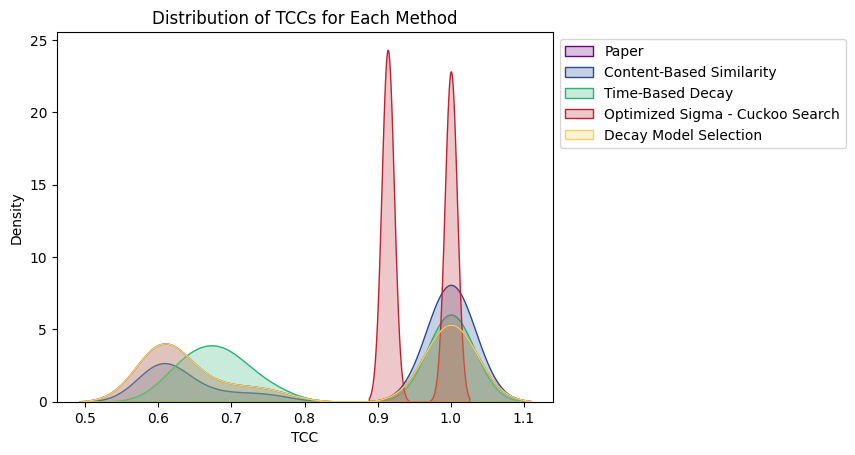

In [54]:
sns.kdeplot(data=df, x='tcc_0', label='Paper', color=color_0, fill=True)
sns.kdeplot(data=df, x='tcc_1', label='Content-Based Similarity', color=color_1, fill=True)
sns.kdeplot(data=df, x='tcc_2', label='Time-Based Decay', color=color_2, fill=True)
sns.kdeplot(data=df, x='tcc_3', label='Optimized Sigma - Cuckoo Search', color=color_3, fill=True)
sns.kdeplot(data=df, x='tcc_4', label='Decay Model Selection', color=color_4, fill=True)
plt.xlabel('TCC')
plt.ylabel('Density')
plt.title('Distribution of TCCs for Each Method')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

Use surprise package to build a recommender system using the new dataframe

In [55]:
def custom_train_test_split(df, target_user_id, rating_column, test_size=0.2):
    # Separate the target user's data
    target_user_data = df[df['user_id'] == target_user_id]
    other_data = df[df['user_id'] != target_user_id]
    
    # Load data into Surprise dataset
    reader = Reader(rating_scale=(1, 5))
    data = Dataset.load_from_df(other_data[['user_id', 'parent_asin', rating_column]], reader)
    
    # Perform the train-test split
    train_data, test_data = train_test_split(data, test_size=test_size)
    
    # Convert train and test sets to DataFrames
    train_df = pd.DataFrame(train_data.all_ratings(), columns=['user_id', 'parent_asin', rating_column])
    test_df = pd.DataFrame(test_data, columns=['user_id', 'parent_asin', rating_column])
    
    # Add the target user's data to the test set
    test_df = pd.concat([test_df, target_user_data[['user_id', 'parent_asin', rating_column]]])
    
    # Add a dummy timestamp column
    test_df['timestamp'] = 0
    
    # Convert DataFrames back to Surprise Datasets
    train_dataset = Dataset.load_from_df(train_df[['user_id', 'parent_asin', rating_column]], reader)
    test_dataset = Dataset.load_from_df(test_df[['user_id', 'parent_asin', rating_column]], reader)
    
    # Convert to Trainset and Testset
    trainset = train_dataset.build_full_trainset()
    testset = test_dataset.construct_testset(test_df.values)
    
    return trainset, testset

In [56]:
test_size = 0.3

In [57]:
# splid the read data to train and test
train_data_0, test_data_0 = custom_train_test_split(df, target_user_id, 'new_rating_0', test_size)
train_data_1, test_data_1 = custom_train_test_split(df, target_user_id, 'new_rating_1', test_size)
train_data_2, test_data_2 = custom_train_test_split(df, target_user_id, 'new_rating_2', test_size)
train_data_3, test_data_3 = custom_train_test_split(df, target_user_id, 'new_rating_3', test_size)
train_data_4, test_data_4 = custom_train_test_split(df, target_user_id, 'new_rating_4', test_size)

In [58]:
# train the data_0 using SVD algorithm
algo_0 = SVD()
algo_0.fit(train_data_0)

# test the trained model
predictions_0 = algo_0.test(test_data_0)

In [59]:
mae_0 = accuracy.mae(predictions_0)
p_0, r_0, f_0 = precision_recall_fmeasure(predictions_0)
print(f'Precision: {p_0:.4f}')
print(f'Recall: {r_0:.4f}')
print(f'F-measure: {f_0:.4f}')

MAE:  1.2455
Precision: 0.6729
Recall: 1.0000
F-measure: 0.7012


In [60]:
# train the data_1 using SVD algorithm
algo_1 = SVD()
algo_1.fit(train_data_1)

# test the trained model
predictions_1 = algo_1.test(test_data_1)

In [61]:
mae_1 = accuracy.mae(predictions_1)
p_1, r_1, f_1 = precision_recall_fmeasure(predictions_1)
print(f'Precision: {p_1:.4f}')
print(f'Recall: {r_1:.4f}')
print(f'F-measure: {f_1:.4f}')

MAE:  1.2526
Precision: 0.7191
Recall: 1.0000
F-measure: 0.7461


In [62]:
# train the data_2 using SVD algorithm
algo_2 = SVD()
algo_2.fit(train_data_2)

# test the trained model
predictions_2 = algo_2.test(test_data_2)

In [63]:
mae_2 = accuracy.mae(predictions_2)
p_2, r_2, f_2 = precision_recall_fmeasure(predictions_2)
print(f'Precision: {p_2:.4f}')
print(f'Recall: {r_2:.4f}')
print(f'F-measure: {f_2:.4f}')

MAE:  1.2131
Precision: 0.6705
Recall: 1.0000
F-measure: 0.7041


In [64]:
# train the data_3 using SVD algorithm
algo_3 = SVD()
algo_3.fit(train_data_3)

# test the trained model
predictions_3 = algo_3.test(test_data_3)

In [65]:
mae_3 = accuracy.mae(predictions_3)
p_3, r_3, f_3 = precision_recall_fmeasure(predictions_3)
print(f'Precision: {p_3:.4f}')
print(f'Recall: {r_3:.4f}')
print(f'F-measure: {f_3:.4f}')

MAE:  1.2087
Precision: 0.7803
Recall: 1.0000
F-measure: 0.8017


In [66]:
# train the data_4 using SVD algorithm
algo_4 = SVD()
algo_4.fit(train_data_4)

# test the trained model
predictions_4 = algo_4.test(test_data_4)

In [67]:
mae_4 = accuracy.mae(predictions_4)
p_4, r_4, f_4 = precision_recall_fmeasure(predictions_4)
print(f'Precision: {p_4:.4f}')
print(f'Recall: {r_4:.4f}')
print(f'F-measure: {f_4:.4f}')

MAE:  1.2618
Precision: 0.7018
Recall: 1.0000
F-measure: 0.7282


Draw plot to understand the methods difference better

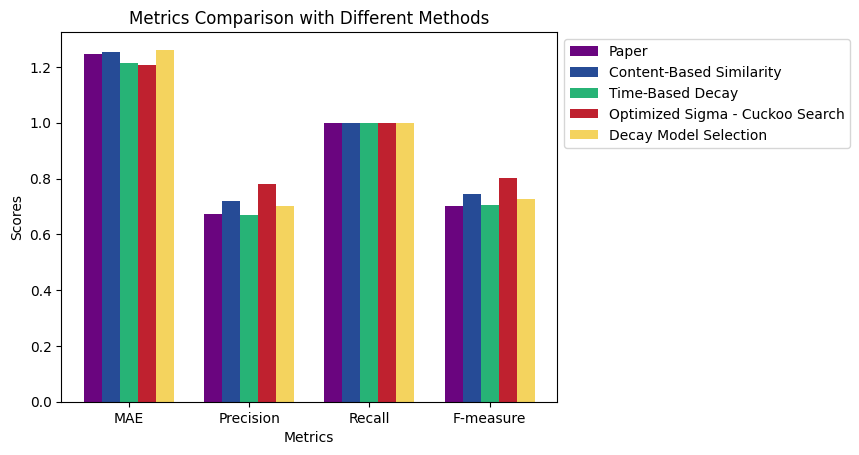

In [68]:
metrics = ['MAE', 'Precision', 'Recall', 'F-measure']

x = np.arange(len(metrics))
y0 = [mae_0, p_0, r_0, f_0]
y1 = [mae_1, p_1, r_1, f_1]
y2 = [mae_2, p_2, r_2, f_2]
y3 = [mae_3, p_3, r_3, f_3]
y4 = [mae_4, p_4, r_4, f_4]
width = 0.15  # the width of the bars

# plot data in grouped manner of bar type 
plt.bar(x-0.3, y0, width, color=color_0) 
plt.bar(x-0.15, y1, width, color=color_1) 
plt.bar(x, y2, width, color=color_2) 
plt.bar(x+0.15, y3, width, color=color_3) 
plt.bar(x+0.3, y4, width, color=color_4)

plt.xticks(x, metrics)
plt.title('Metrics Comparison with Different Methods')
plt.xlabel('Metrics') 
plt.ylabel('Scores') 
plt.legend(
    ['Paper', 'Content-Based Similarity', 'Time-Based Decay', 'Optimized Sigma - Cuckoo Search', 'Decay Model Selection'], 
    loc='upper left', 
    bbox_to_anchor=(1, 1)) 
plt.show() 

In [69]:
metrics = ['MAE', 'Precision', 'Recall', 'F-measure']
methods = ['Paper', 'Content-Based Similarity', 'Time-Based Decay', 'Optimized Sigma - Cuckoo Search', 'Decay Model Selection']

values = {
    'Paper': [mae_0, p_0, r_0, f_0],
    'Content-Based Similarity': [mae_1, p_1, r_1, f_1],
    'Time-Based Decay': [mae_2, p_2, r_2, f_2],
    'Optimized Sigma - Cuckoo Search': [mae_3, p_3, r_3, f_3],
    'Decay Model Selection': [mae_4, p_4, r_4, f_4]
}

metrics_table = pd.DataFrame(values, index=metrics)
metrics_table.head(10)

,Paper,Content-Based Similarity,Time-Based Decay,Optimized Sigma - Cuckoo Search,Decay Model Selection
MAE,1.245497,1.252587,1.213063,1.208660,1.261776
Precision,0.672896,0.719085,0.670470,0.780339,0.701814
Recall,1.000000,1.000000,1.000000,1.000000,1.000000
F-measure,0.701223,0.746100,0.704079,0.801724,0.728154


Function to recommend top n popular items for new user

In [70]:
def get_top_n_popular(predictions, n=10):
    # Calculate item popularity
    item_popularity = {}
    for uid, iid, true_r, est, _ in predictions:
        if iid in item_popularity:
            item_popularity[iid] += est
        else:
            item_popularity[iid] = est
    
    # Sort items by popularity (descending order)
    sorted_items = sorted(item_popularity.items(), key=lambda x: x[1], reverse=True)

    # Return the top-n most popular items
    return [item for item, _ in sorted_items[:n]]

Function to recommend top n products to user

In [71]:
def get_top_n(predictions, n=10):
    # First map the predictions to each user.
    top_n = {}
    for uid, iid, true_r, est, _ in predictions:
        if uid in top_n:
            top_n[uid].append((iid, est))
        else:
            top_n[uid] = [(iid, est)]

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
        
    # Get the top-n popular items
    top_n_popular = get_top_n_popular(predictions, n)

    # Fill up the remaining spots with popular items
    for uid, user_ratings in top_n.items():
        if len(user_ratings) < n:
            remaining_spots = n - len(user_ratings)
            top_n[uid].extend(top_n_popular[:remaining_spots])

    return top_n

In [72]:
# get the top recommended n items for all users in predicted dataset
top_n_0 = get_top_n(predictions_0, n=10)

In [73]:
# Print the recommended items for the target user we chose previously
if target_user_id in top_n_0:
    user_recommendations = top_n_0[target_user_id]
    print(f'Top 10 recommended products for user {target_user_id}:')
    for i in range(len(user_recommendations)):
        if type(user_recommendations[i]) == tuple:
            product_meta = meta_data[meta_data['parent_asin'] == user_recommendations[i][0]]
        else:
            print('* ', end='')
            product_meta = meta_data[meta_data['parent_asin'] == user_recommendations[i]]
        print(f"{i + 1}. {product_meta['title'].values[0]}")
else:
    print(len(df[df['user_id'] == target_user_id]))

Top 10 recommended products for user AHK5WGRRDPYA6IT5NKH7ZLKH4ECQ:
1. JETech Slim Fit Case for iPhone SE 2nd Generation, iPhone 8 and iPhone 7, 2-Layer Protective Cover, Thin, Carbon Fiber, Grey
2. Mr Shield [Tempered Glass] Screen Protector For iPhone 6 / iPhone 6S / iPhone 7 / iPhone 8 [3-Pack] Screen Protector
3. iPhone 11 Pro Max Case, Shockproof Ultra Slim Fit Silicone Black Cover TPU Soft Gel Rubber Cover Shock Resistance Protective Back Bumper for Apple iPhone 11 Pro Max Black
* 4. JOTO Universal Waterproof Phone Pouch Cellphone Dry Bag Case Compatible with iPhone 14 13 12 11 Pro Max Mini Xs XR X 8 7 6S Plus SE, Galaxy S21 S20 S10 Plus Note 10+ 9, Pixel 4 XL up to 7" -Green
* 5. Ailun Glass Screen Protector Compatible for iPhone 11/XR,6.1 Inch 3 Pack Tempered Glass
* 6. Amazon Basics Multi-tip Stylus Tablet Pen for Touchscreen Devices - Black, 4-Pack
* 7. The Friendly Swede Replacement Tips for The Friendly Swede Stylus Pen 5.5" with Replaceable Thin-Tip, iPad Pointer Rubber Tip

In [74]:
# Print the recommended items for a random user
user_recommendations = top_n_0[list(top_n_0.keys())[random.randint(0, len(top_n_0))]]
print(f'Top 10 recommended products for user {user_id}:')

for i in range(len(user_recommendations)):
    if type(user_recommendations[i]) == tuple:
        product_meta = meta_data[meta_data['parent_asin'] == user_recommendations[i][0]]
    else:
        print('* ', end='')
        product_meta = meta_data[meta_data['parent_asin'] == user_recommendations[i]]
    
    print(f"{i + 1}. {product_meta['title'].values[0]}")

Top 10 recommended products for user AHZZJQYNVZUJNPNQ737ITGEQUB4A:
1. Supershieldz (3 Pack) Designed for Samsung Galaxy A53 5G / A52 / A52 5G / A51 / A51 5G / A51 5G UW Tempered Glass Screen Protector, Anti Scratch, Bubble Free
* 2. JOTO Universal Waterproof Phone Pouch Cellphone Dry Bag Case Compatible with iPhone 14 13 12 11 Pro Max Mini Xs XR X 8 7 6S Plus SE, Galaxy S21 S20 S10 Plus Note 10+ 9, Pixel 4 XL up to 7" -Green
* 3. Ailun Glass Screen Protector Compatible for iPhone 11/XR,6.1 Inch 3 Pack Tempered Glass
* 4. Amazon Basics Multi-tip Stylus Tablet Pen for Touchscreen Devices - Black, 4-Pack
* 5. The Friendly Swede Replacement Tips for The Friendly Swede Stylus Pen 5.5" with Replaceable Thin-Tip, iPad Pointer Rubber Tip Stylus Tips, Fine Tip Stylus Replacement Tips - 12 Pieces Stylus Pen Tips
* 6. Mkeke Compatible with iPhone 11 Screen Protector for iPhone XR Screen Protector, Tempered Glass Film for Apple iPhone 11 and iPhone XR, 3-Pack Clear
* 7. JETech Case for iPhone 6 an

In [75]:
# get the top recommended n items for all users in predicted dataset
top_n_1 = get_top_n(predictions_1, n=10)

In [76]:
# Print the recommended items for the target user we chose previously
if target_user_id in top_n_1:
    user_recommendations = top_n_1[target_user_id]
    print(f'Top 10 recommended products for user {target_user_id}:')
    for i in range(len(user_recommendations)):
        if type(user_recommendations[i]) == tuple:
            product_meta = meta_data[meta_data['parent_asin'] == user_recommendations[i][0]]
        else:
            print('* ', end='')
            product_meta = meta_data[meta_data['parent_asin'] == user_recommendations[i]]
        print(f"{i + 1}. {product_meta['title'].values[0]}")
else:
    print(len(df[df['user_id'] == target_user_id]))

Top 10 recommended products for user AHK5WGRRDPYA6IT5NKH7ZLKH4ECQ:
1. JETech Slim Fit Case for iPhone SE 2nd Generation, iPhone 8 and iPhone 7, 2-Layer Protective Cover, Thin, Carbon Fiber, Grey
2. Mr Shield [Tempered Glass] Screen Protector For iPhone 6 / iPhone 6S / iPhone 7 / iPhone 8 [3-Pack] Screen Protector
3. iPhone 11 Pro Max Case, Shockproof Ultra Slim Fit Silicone Black Cover TPU Soft Gel Rubber Cover Shock Resistance Protective Back Bumper for Apple iPhone 11 Pro Max Black
* 4. amFilm Screen Protector 4.7“ for Apple iPhone 8, iPhone 7, iPhone 6S and iPhone 6, Tempered Glass 4.7“, 2 Pack
* 5. Stylus, iBart Mesh Fiber Tip Series Precision Stylus Pens for Touch Screens Devices, iPhone, iPad, Kindle, Tablet (10 Colors)
* 6. JOTO Universal Waterproof Phone Pouch Cellphone Dry Bag Case Compatible with iPhone 14 13 12 11 Pro Max Mini Xs XR X 8 7 6S Plus SE, Galaxy S21 S20 S10 Plus Note 10+ 9, Pixel 4 XL up to 7" -Green
* 7. Mr Shield [Tempered Glass] Screen Protector For iPhone 6 /

In [77]:
# Print the recommended items for a random user
user_recommendations = top_n_1[list(top_n_1.keys())[random.randint(0, len(top_n_1))]]
print(f'Top 10 recommended products for user {user_id}:')

for i in range(len(user_recommendations)):
    if type(user_recommendations[i]) == tuple:
        product_meta = meta_data[meta_data['parent_asin'] == user_recommendations[i][0]]
    else:
        print('* ', end='')
        product_meta = meta_data[meta_data['parent_asin'] == user_recommendations[i]]
    
    print(f"{i + 1}. {product_meta['title'].values[0]}")

Top 10 recommended products for user AHZZJQYNVZUJNPNQ737ITGEQUB4A:
1. Galaxy S7 Waterproof Case, Ghostek Atomic 2.0 Series for Samsung Galaxy S7 (Pink)
* 2. amFilm Screen Protector 4.7“ for Apple iPhone 8, iPhone 7, iPhone 6S and iPhone 6, Tempered Glass 4.7“, 2 Pack
* 3. Stylus, iBart Mesh Fiber Tip Series Precision Stylus Pens for Touch Screens Devices, iPhone, iPad, Kindle, Tablet (10 Colors)
* 4. JOTO Universal Waterproof Phone Pouch Cellphone Dry Bag Case Compatible with iPhone 14 13 12 11 Pro Max Mini Xs XR X 8 7 6S Plus SE, Galaxy S21 S20 S10 Plus Note 10+ 9, Pixel 4 XL up to 7" -Green
* 5. Mr Shield [Tempered Glass] Screen Protector For iPhone 6 / iPhone 6S / iPhone 7 / iPhone 8 [3-Pack] Screen Protector
* 6. OMOTON 9H Hardness HD Tempered Glass Screen Protector for Apple iPhone 8 Plus / iPhone 7 Plus, 2 Pack
* 7. UniqueMe [2+2 Pack] Camera Lens Protector and Screen Protector for Samsung Galaxy A71 4G / 5G,Tempered Glass [Easy Installation Frame] HD Clear [Anti-Scratch] [Bubble

In [78]:
# get the top recommended n items for all users in predicted dataset
top_n_2 = get_top_n(predictions_2, n=10)

In [79]:
# Print the recommended items for the target user we chose previously
if target_user_id in top_n_2:
    user_recommendations = top_n_2[target_user_id]
    print(f'Top 10 recommended products for user {target_user_id}:')
    for i in range(len(user_recommendations)):
        if type(user_recommendations[i]) == tuple:
            product_meta = meta_data[meta_data['parent_asin'] == user_recommendations[i][0]]
        else:
            print('* ', end='')
            product_meta = meta_data[meta_data['parent_asin'] == user_recommendations[i]]
        print(f"{i + 1}. {product_meta['title'].values[0]}")
else:
    print(len(df[df['user_id'] == target_user_id]))

Top 10 recommended products for user AHK5WGRRDPYA6IT5NKH7ZLKH4ECQ:
1. JETech Slim Fit Case for iPhone SE 2nd Generation, iPhone 8 and iPhone 7, 2-Layer Protective Cover, Thin, Carbon Fiber, Grey
2. Mr Shield [Tempered Glass] Screen Protector For iPhone 6 / iPhone 6S / iPhone 7 / iPhone 8 [3-Pack] Screen Protector
3. iPhone 11 Pro Max Case, Shockproof Ultra Slim Fit Silicone Black Cover TPU Soft Gel Rubber Cover Shock Resistance Protective Back Bumper for Apple iPhone 11 Pro Max Black
* 4. JOTO Universal Waterproof Phone Pouch Cellphone Dry Bag Case Compatible with iPhone 14 13 12 11 Pro Max Mini Xs XR X 8 7 6S Plus SE, Galaxy S21 S20 S10 Plus Note 10+ 9, Pixel 4 XL up to 7" -Green
* 5. amFilm Screen Protector 4.7“ for Apple iPhone 8, iPhone 7, iPhone 6S and iPhone 6, Tempered Glass 4.7“, 2 Pack
* 6. Mr Shield [Tempered Glass] Screen Protector For iPhone 6 / iPhone 6S / iPhone 7 / iPhone 8 [3-Pack] Screen Protector
* 7. Phone Tripod LINKCOOL 360 Degree Rotation Flexible Tripod Travel Oc

In [80]:
# Print the recommended items for a random user
user_recommendations = top_n_2[list(top_n_2.keys())[random.randint(0, len(top_n_2))]]
print(f'Top 10 recommended products for user {user_id}:')

for i in range(len(user_recommendations)):
    if type(user_recommendations[i]) == tuple:
        product_meta = meta_data[meta_data['parent_asin'] == user_recommendations[i][0]]
    else:
        print('* ', end='')
        product_meta = meta_data[meta_data['parent_asin'] == user_recommendations[i]]
    
    print(f"{i + 1}. {product_meta['title'].values[0]}")

Top 10 recommended products for user AHZZJQYNVZUJNPNQ737ITGEQUB4A:
1. Anuck Case for iPhone 8 Case, for iPhone 7 Case (4.7 inch), 3 in 1 Hybrid Heavy Duty Defender Case Sparkly Floating Liquid Glitter Protective Hard Shell Shockproof TPU Cover - Rose Gold
* 2. JOTO Universal Waterproof Phone Pouch Cellphone Dry Bag Case Compatible with iPhone 14 13 12 11 Pro Max Mini Xs XR X 8 7 6S Plus SE, Galaxy S21 S20 S10 Plus Note 10+ 9, Pixel 4 XL up to 7" -Green
* 3. amFilm Screen Protector 4.7“ for Apple iPhone 8, iPhone 7, iPhone 6S and iPhone 6, Tempered Glass 4.7“, 2 Pack
* 4. Mr Shield [Tempered Glass] Screen Protector For iPhone 6 / iPhone 6S / iPhone 7 / iPhone 8 [3-Pack] Screen Protector
* 5. Phone Tripod LINKCOOL 360 Degree Rotation Flexible Tripod Travel Octopus Tripod for iPhone/Smartphone/Ipad/DSLR/Sports Action Camera, with Bluetooth Wireless Remote Shutter
* 6. Mkeke Compatible with iPhone 11 Screen Protector for iPhone XR Screen Protector, Tempered Glass Film for Apple iPhone 11 a

In [81]:
# get the top recommended n items for all users in predicted dataset
top_n_3 = get_top_n(predictions_3, n=10)

In [82]:
# Print the recommended items for the target user we chose previously
if target_user_id in top_n_3:
    user_recommendations = top_n_3[target_user_id]
    print(f'Top 10 recommended products for user {target_user_id}:')
    for i in range(len(user_recommendations)):
        if type(user_recommendations[i]) == tuple:
            product_meta = meta_data[meta_data['parent_asin'] == user_recommendations[i][0]]
        else:
            print('* ', end='')
            product_meta = meta_data[meta_data['parent_asin'] == user_recommendations[i]]
        print(f"{i + 1}. {product_meta['title'].values[0]}")
else:
    print(len(df[df['user_id'] == target_user_id]))

Top 10 recommended products for user AHK5WGRRDPYA6IT5NKH7ZLKH4ECQ:
1. JETech Slim Fit Case for iPhone SE 2nd Generation, iPhone 8 and iPhone 7, 2-Layer Protective Cover, Thin, Carbon Fiber, Grey
2. Mr Shield [Tempered Glass] Screen Protector For iPhone 6 / iPhone 6S / iPhone 7 / iPhone 8 [3-Pack] Screen Protector
3. iPhone 11 Pro Max Case, Shockproof Ultra Slim Fit Silicone Black Cover TPU Soft Gel Rubber Cover Shock Resistance Protective Back Bumper for Apple iPhone 11 Pro Max Black
* 4. OMOTON 9H Hardness HD Tempered Glass Screen Protector for Apple iPhone 8 Plus / iPhone 7 Plus, 2 Pack
* 5. amFilm Screen Protector 4.7“ for Apple iPhone 8, iPhone 7, iPhone 6S and iPhone 6, Tempered Glass 4.7“, 2 Pack
* 6. Mkeke Compatible with iPhone 11 Screen Protector for iPhone XR Screen Protector, Tempered Glass Film for Apple iPhone 11 and iPhone XR, 3-Pack Clear
* 7. JOTO Universal Waterproof Phone Pouch Cellphone Dry Bag Case Compatible with iPhone 14 13 12 11 Pro Max Mini Xs XR X 8 7 6S Plus 

In [83]:
# Print the recommended items for a random user
user_recommendations = top_n_3[list(top_n_3.keys())[random.randint(0, len(top_n_3))]]
print(f'Top 10 recommended products for user {user_id}:')

for i in range(len(user_recommendations)):
    if type(user_recommendations[i]) == tuple:
        product_meta = meta_data[meta_data['parent_asin'] == user_recommendations[i][0]]
    else:
        print('* ', end='')
        product_meta = meta_data[meta_data['parent_asin'] == user_recommendations[i]]
    
    print(f"{i + 1}. {product_meta['title'].values[0]}")

Top 10 recommended products for user AHZZJQYNVZUJNPNQ737ITGEQUB4A:
1. Rugged 4-in-1 Selfie Stick Tripod Stand Kit + Bluetooth Remote – Universal: Any iPhone, Android, GoPro or Camera – iPhone 13 12 11 Pro Mini Max XS XR X 8 7 6 Plus, Samsung etc.
* 2. OMOTON 9H Hardness HD Tempered Glass Screen Protector for Apple iPhone 8 Plus / iPhone 7 Plus, 2 Pack
* 3. amFilm Screen Protector 4.7“ for Apple iPhone 8, iPhone 7, iPhone 6S and iPhone 6, Tempered Glass 4.7“, 2 Pack
* 4. Mkeke Compatible with iPhone 11 Screen Protector for iPhone XR Screen Protector, Tempered Glass Film for Apple iPhone 11 and iPhone XR, 3-Pack Clear
* 5. JOTO Universal Waterproof Phone Pouch Cellphone Dry Bag Case Compatible with iPhone 14 13 12 11 Pro Max Mini Xs XR X 8 7 6S Plus SE, Galaxy S21 S20 S10 Plus Note 10+ 9, Pixel 4 XL up to 7" -Green
* 6. Ailun Glass Screen Protector Compatible for iPhone 11/XR,6.1 Inch 3 Pack Tempered Glass
* 7. JETech Screen Protector for iPhone 11 and iPhone XR, 6.1-Inch, Tempered Glass

In [84]:
# get the top recommended n items for all users in predicted dataset
top_n_4 = get_top_n(predictions_4, n=10)

In [85]:
# Print the recommended items for the target user we chose previously
if target_user_id in top_n_4:
    user_recommendations = top_n_4[target_user_id]
    print(f'Top 10 recommended products for user {target_user_id}:')
    for i in range(len(user_recommendations)):
        if type(user_recommendations[i]) == tuple:
            product_meta = meta_data[meta_data['parent_asin'] == user_recommendations[i][0]]
        else:
            print('* ', end='')
            product_meta = meta_data[meta_data['parent_asin'] == user_recommendations[i]]
        print(f"{i + 1}. {product_meta['title'].values[0]}")
else:
    print(len(df[df['user_id'] == target_user_id]))

Top 10 recommended products for user AHK5WGRRDPYA6IT5NKH7ZLKH4ECQ:
1. JETech Slim Fit Case for iPhone SE 2nd Generation, iPhone 8 and iPhone 7, 2-Layer Protective Cover, Thin, Carbon Fiber, Grey
2. Mr Shield [Tempered Glass] Screen Protector For iPhone 6 / iPhone 6S / iPhone 7 / iPhone 8 [3-Pack] Screen Protector
3. iPhone 11 Pro Max Case, Shockproof Ultra Slim Fit Silicone Black Cover TPU Soft Gel Rubber Cover Shock Resistance Protective Back Bumper for Apple iPhone 11 Pro Max Black
* 4. amFilm Screen Protector 4.7“ for Apple iPhone 8, iPhone 7, iPhone 6S and iPhone 6, Tempered Glass 4.7“, 2 Pack
* 5. OMOTON 9H Hardness HD Tempered Glass Screen Protector for Apple iPhone 8 Plus / iPhone 7 Plus, 2 Pack
* 6. JETech Screen Protector for iPhone 8 Plus and iPhone 7 Plus, 5.5-Inch, Tempered Glass Film, 2-Pack
* 7. OTTERBOX DEFENDER iPhone 6 PLUS/6s PLUS Case - Retail Packaging - INDIGO HARBOR (ROYAL BLUE/ADMIRAL BLUE)
* 8. TRIBE Running Phone Holder Armband. iPhone & Galaxy Cell Phone Sport

In [86]:
# Print the recommended items for a random user
user_recommendations = top_n_4[list(top_n_4.keys())[random.randint(0, len(top_n_4))]]
print(f'Top 10 recommended products for user {user_id}:')

for i in range(len(user_recommendations)):
    if type(user_recommendations[i]) == tuple:
        product_meta = meta_data[meta_data['parent_asin'] == user_recommendations[i][0]]
    else:
        print('* ', end='')
        product_meta = meta_data[meta_data['parent_asin'] == user_recommendations[i]]
    
    print(f"{i + 1}. {product_meta['title'].values[0]}")

Top 10 recommended products for user AHZZJQYNVZUJNPNQ737ITGEQUB4A:
1. TRIBE Running Phone Holder Armband. iPhone & Galaxy Cell Phone Sports Arm Bands for Women, Men, Runners, Jogging, Walking, Exercise & Gym Workout. Fits All Smartphones. Adjustable Strap, CC/Key Pocket
* 2. amFilm Screen Protector 4.7“ for Apple iPhone 8, iPhone 7, iPhone 6S and iPhone 6, Tempered Glass 4.7“, 2 Pack
* 3. OMOTON 9H Hardness HD Tempered Glass Screen Protector for Apple iPhone 8 Plus / iPhone 7 Plus, 2 Pack
* 4. JETech Screen Protector for iPhone 8 Plus and iPhone 7 Plus, 5.5-Inch, Tempered Glass Film, 2-Pack
* 5. OTTERBOX DEFENDER iPhone 6 PLUS/6s PLUS Case - Retail Packaging - INDIGO HARBOR (ROYAL BLUE/ADMIRAL BLUE)
* 6. TRIBE Running Phone Holder Armband. iPhone & Galaxy Cell Phone Sports Arm Bands for Women, Men, Runners, Jogging, Walking, Exercise & Gym Workout. Fits All Smartphones. Adjustable Strap, CC/Key Pocket
* 7. Mkeke Compatible with iPhone 11 Screen Protector for iPhone XR Screen Protector,

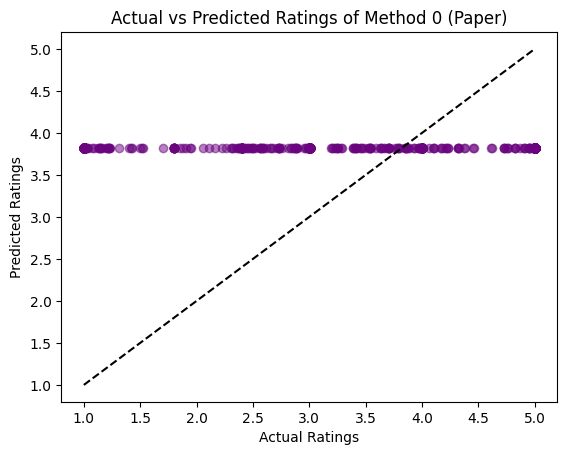

In [87]:
actual = [pred.r_ui for pred in predictions_0]
predicted = [pred.est for pred in predictions_0]
plt.scatter(actual, predicted, alpha=0.5, color=color_0)
# Add a line where x = y
limits = [min(min(actual), min(predicted)),  # find lower limit among actual and predicted ratings
              max(max(actual), max(predicted))]  # find upper limit among actual and predicted ratings
plt.plot(limits, limits, 'k--')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Actual vs Predicted Ratings of Method 0 (Paper)')
plt.show()

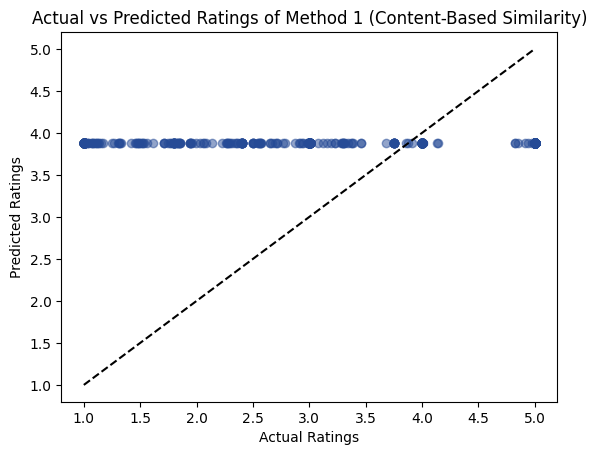

In [88]:
actual = [pred.r_ui for pred in predictions_1]
predicted = [pred.est for pred in predictions_1]
plt.scatter(actual, predicted, alpha=0.5, color=color_1)
# Add a line where x = y
limits = [min(min(actual), min(predicted)),  # find lower limit among actual and predicted ratings
              max(max(actual), max(predicted))]  # find upper limit among actual and predicted ratings
plt.plot(limits, limits, 'k--')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Actual vs Predicted Ratings of Method 1 (Content-Based Similarity)')
plt.show()

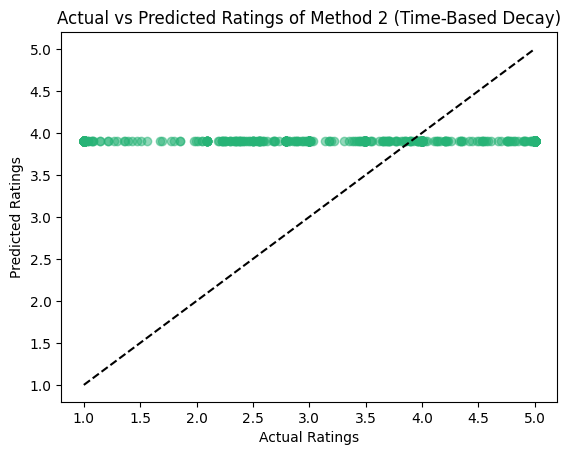

In [89]:
actual = [pred.r_ui for pred in predictions_2]
predicted = [pred.est for pred in predictions_2]
plt.scatter(actual, predicted, alpha=0.5, color=color_2)
# Add a line where x = y
limits = [min(min(actual), min(predicted)),  # find lower limit among actual and predicted ratings
              max(max(actual), max(predicted))]  # find upper limit among actual and predicted ratings
plt.plot(limits, limits, 'k--')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Actual vs Predicted Ratings of Method 2 (Time-Based Decay)')
plt.show()

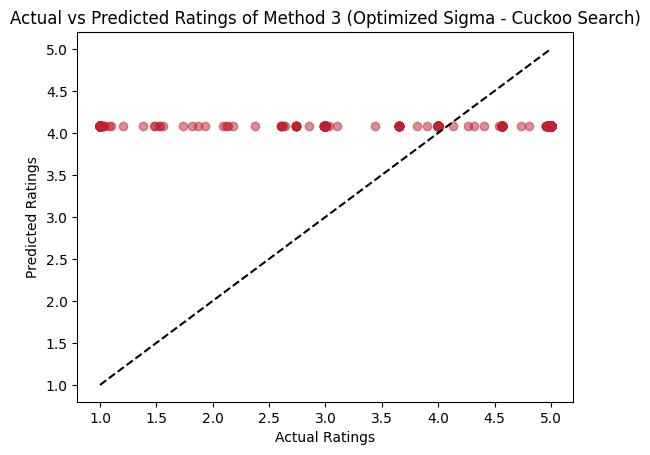

In [90]:
actual = [pred.r_ui for pred in predictions_3]
predicted = [pred.est for pred in predictions_3]
plt.scatter(actual, predicted, alpha=0.5, color=color_3)
# Add a line where x = y
limits = [min(min(actual), min(predicted)),  # find lower limit among actual and predicted ratings
              max(max(actual), max(predicted))]  # find upper limit among actual and predicted ratings
plt.plot(limits, limits, 'k--')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Actual vs Predicted Ratings of Method 3 (Optimized Sigma - Cuckoo Search)')
plt.show()

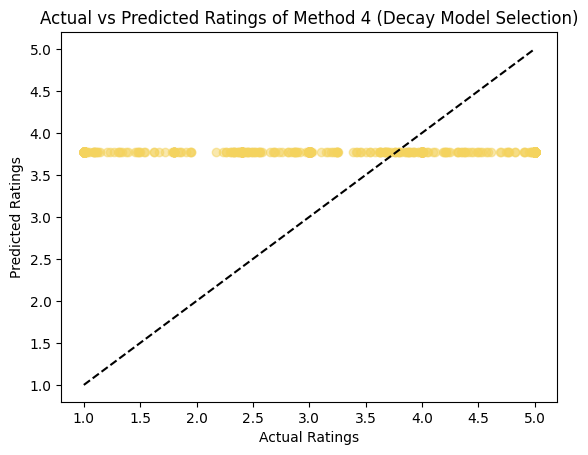

In [91]:
actual = [pred.r_ui for pred in predictions_4]
predicted = [pred.est for pred in predictions_4]
plt.scatter(actual, predicted, alpha=0.5, color=color_4)
# Add a line where x = y
limits = [min(min(actual), min(predicted)),  # find lower limit among actual and predicted ratings
              max(max(actual), max(predicted))]  # find upper limit among actual and predicted ratings
plt.plot(limits, limits, 'k--')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Actual vs Predicted Ratings of Method 4 (Decay Model Selection)')
plt.show()